In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv2D
from tensorflow.keras.layers import MaxPooling2D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(os.path.join(data_dir, 'train_data.npz'))
val_data = np.load(os.path.join(data_dir, 'validation_data.npz'))
test_data = np.load(os.path.join(data_dir, 'test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 25443),
 (36805,),
 (4293, 25443),
 (4293,),
 (4815, 25443),
 (4815,),
 (16, 2))

In [6]:
def preprocess(x_data):
    x_data = np.reshape(x_data, [x_data.shape[0], 99, 257, 1])
    x_data = np.rot90(x_data, 1, (1, 2))
    return x_data

In [7]:
output_size = y_table.shape[0]

In [8]:
x_train_2d = preprocess(x_train)
mean_vals = np.mean(x_train_2d, axis=0)
std_val = np.std(x_train_2d)
x_train_2d_norm = (x_train_2d-mean_vals) / std_val
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_2d = preprocess(x_val)
x_val_2d_norm = (x_val_2d-mean_vals) / std_val
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_2d = preprocess(x_test)
x_test_2d_norm = (x_test_2d-mean_vals) / std_val
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [9]:
input_shape = x_test_2d_norm[0].shape

In [10]:
def build_2d_cnn_only_conv_DO_BN(conv_num=1):
    model=Sequential()
    model.add(Conv2D (kernel_size=5, filters=8, strides=(1,1), padding='valid', 
                      activation='relu', input_shape=input_shape)) 
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=2, strides=(2,2), padding='same'))
    
    for i in range(conv_num-1):
        model.add(Conv2D (kernel_size=5, filters=8*(2**(i+1)), strides=(1,1), padding='valid', 
                          activation='relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=2, strides=(2,2), padding='same'))

    model.add(Flatten())
    
    model.add(Dropout(0.5))
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [11]:
for i in range(1, 5):
    model = build_2d_cnn_only_conv_DO_BN(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/200
36800/36805 [============================>.] - ETA: 0s - loss: 2.3278 - acc: 0.3895
Epoch 00001: val_loss improved from inf to 1.58937, saving model to model/checkpoint/2D_CNN_1_only_conv_DO_BN_checkpoint/01-1.5894.hdf5
36805/36805 [==============================] - 13s 343us/sample - loss: 2.3277 - acc: 0.3895 - val_loss: 1.5894 - val_acc: 0.5348
Epoch 2/200
36800/36805 [============================>.] - ETA: 0s - loss: 1.5904 - acc: 0.5468
Epoch 00002: val_loss improved from 1.58937 to 1.24968, saving model to model/checkpoint/2D_CNN_1_only_conv_DO_BN_checkpoint/02-1.2497.hdf5
36805/36805 [==============================] - 11s 297us/sample - loss: 1.5904 - acc: 0.5468 - val_loss: 1.2497 - val_

36800/36805 [============================>.] - ETA: 0s - loss: 0.4181 - acc: 0.8636
Epoch 00025: val_loss did not improve from 1.15500
36805/36805 [==============================] - 11s 293us/sample - loss: 0.4180 - acc: 0.8636 - val_loss: 1.3771 - val_acc: 0.7151
Epoch 26/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.4179 - acc: 0.8651
Epoch 00026: val_loss did not improve from 1.15500
36805/36805 [==============================] - 11s 294us/sample - loss: 0.4179 - acc: 0.8651 - val_loss: 1.3571 - val_acc: 0.7172
Epoch 27/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.4211 - acc: 0.8627
Epoch 00027: val_loss did not improve from 1.15500
36805/36805 [==============================] - 11s 292us/sample - loss: 0.4211 - acc: 0.8627 - val_loss: 1.3621 - val_acc: 0.7235
Epoch 28/200
36672/36805 [============================>.] - ETA: 0s - loss: 0.4116 - acc: 0.8669
Epoch 00028: val_loss did not improve from 1.15500
36805/36805 [==================

Epoch 55/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.3097 - acc: 0.9020
Epoch 00055: val_loss did not improve from 1.15500
36805/36805 [==============================] - 11s 294us/sample - loss: 0.3097 - acc: 0.9020 - val_loss: 1.4886 - val_acc: 0.7221
Epoch 56/200
36672/36805 [============================>.] - ETA: 0s - loss: 0.3054 - acc: 0.9023
Epoch 00056: val_loss did not improve from 1.15500
36805/36805 [==============================] - 11s 295us/sample - loss: 0.3058 - acc: 0.9023 - val_loss: 1.4733 - val_acc: 0.7370
Epoch 57/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.3030 - acc: 0.9027
Epoch 00057: val_loss did not improve from 1.15500
36805/36805 [==============================] - 11s 292us/sample - loss: 0.3030 - acc: 0.9027 - val_loss: 1.4737 - val_acc: 0.7338
Epoch 58/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.2972 - acc: 0.9032
Epoch 00058: val_loss did not improve from 1.15500
36805/36805 [=====

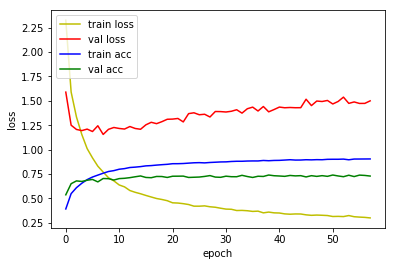

4815/4815 [==============================] - 1s 260us/sample - loss: 1.2750 - acc: 0.6598
Loss: 1.2749793017764701 Accuracy: 0.6598131

Train on 36805 samples, validate on 4293 samples
Epoch 1/200
36800/36805 [============================>.] - ETA: 0s - loss: 2.3710 - acc: 0.3895
Epoch 00001: val_loss improved from inf to 1.35675, saving model to model/checkpoint/2D_CNN_2_only_conv_DO_BN_checkpoint/01-1.3568.hdf5
36805/36805 [==============================] - 14s 393us/sample - loss: 2.3715 - acc: 0.3895 - val_loss: 1.3568 - val_acc: 0.6087
Epoch 2/200
36672/36805 [============================>.] - ETA: 0s - loss: 1.5333 - acc: 0.5706
Epoch 00002: val_loss improved from 1.35675 to 1.04623, saving model to model/checkpoint/2D_CNN_2_only_conv_DO_BN_checkpoint/02-1.0462.hdf5
36805/36805 [==============================] - 13s 360us/sample - loss: 1.5329 - acc: 0.5707 - val_loss: 1.0462 - val_acc: 0.7077
Epoch 3/200
36672/36805 [============================>.] - ETA: 0s - loss: 1.2197 - acc

36736/36805 [============================>.] - ETA: 0s - loss: 0.2105 - acc: 0.9310
Epoch 00026: val_loss did not improve from 0.54094
36805/36805 [==============================] - 13s 357us/sample - loss: 0.2105 - acc: 0.9310 - val_loss: 0.5851 - val_acc: 0.8714
Epoch 27/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.2080 - acc: 0.9312
Epoch 00027: val_loss did not improve from 0.54094
36805/36805 [==============================] - 13s 351us/sample - loss: 0.2082 - acc: 0.9311 - val_loss: 0.5729 - val_acc: 0.8749
Epoch 28/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.1929 - acc: 0.9364
Epoch 00028: val_loss did not improve from 0.54094
36805/36805 [==============================] - 13s 346us/sample - loss: 0.1929 - acc: 0.9364 - val_loss: 0.5647 - val_acc: 0.8819
Epoch 29/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.1883 - acc: 0.9395
Epoch 00029: val_loss did not improve from 0.54094
36805/36805 [==================

Epoch 56/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.1082 - acc: 0.9646
Epoch 00056: val_loss did not improve from 0.54094
36805/36805 [==============================] - 13s 347us/sample - loss: 0.1081 - acc: 0.9646 - val_loss: 0.6370 - val_acc: 0.8903
Epoch 57/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.1095 - acc: 0.9643
Epoch 00057: val_loss did not improve from 0.54094
36805/36805 [==============================] - 13s 364us/sample - loss: 0.1095 - acc: 0.9644 - val_loss: 0.6458 - val_acc: 0.8835
Epoch 58/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.1133 - acc: 0.9638
Epoch 00058: val_loss did not improve from 0.54094
36805/36805 [==============================] - 13s 359us/sample - loss: 0.1134 - acc: 0.9637 - val_loss: 0.6369 - val_acc: 0.8882
Epoch 59/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.1112 - acc: 0.9652
Epoch 00059: val_loss did not improve from 0.54094
36805/36805 [=====

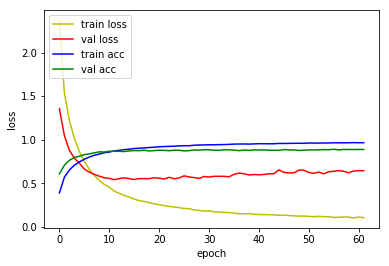

4815/4815 [==============================] - 1s 237us/sample - loss: 0.6045 - acc: 0.8390
Loss: 0.6045244734111481 Accuracy: 0.83904463

Train on 36805 samples, validate on 4293 samples
Epoch 1/200
36736/36805 [============================>.] - ETA: 0s - loss: 2.5483 - acc: 0.3335
Epoch 00001: val_loss improved from inf to 1.37637, saving model to model/checkpoint/2D_CNN_3_only_conv_DO_BN_checkpoint/01-1.3764.hdf5
36805/36805 [==============================] - 17s 450us/sample - loss: 2.5474 - acc: 0.3336 - val_loss: 1.3764 - val_acc: 0.5791
Epoch 2/200
36800/36805 [============================>.] - ETA: 0s - loss: 1.6482 - acc: 0.5292
Epoch 00002: val_loss improved from 1.37637 to 1.01576, saving model to model/checkpoint/2D_CNN_3_only_conv_DO_BN_checkpoint/02-1.0158.hdf5
36805/36805 [==============================] - 14s 389us/sample - loss: 1.6482 - acc: 0.5291 - val_loss: 1.0158 - val_acc: 0.7079
Epoch 3/200
36672/36805 [============================>.] - ETA: 0s - loss: 1.2343 - ac

36672/36805 [============================>.] - ETA: 0s - loss: 0.1881 - acc: 0.9402
Epoch 00024: val_loss did not improve from 0.29518
36805/36805 [==============================] - 14s 394us/sample - loss: 0.1881 - acc: 0.9403 - val_loss: 0.3096 - val_acc: 0.9217
Epoch 25/200
36672/36805 [============================>.] - ETA: 0s - loss: 0.1792 - acc: 0.9427
Epoch 00025: val_loss did not improve from 0.29518
36805/36805 [==============================] - 14s 389us/sample - loss: 0.1792 - acc: 0.9427 - val_loss: 0.3164 - val_acc: 0.9199
Epoch 26/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.1767 - acc: 0.9417
Epoch 00026: val_loss did not improve from 0.29518
36805/36805 [==============================] - 14s 390us/sample - loss: 0.1767 - acc: 0.9417 - val_loss: 0.3085 - val_acc: 0.9241
Epoch 27/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.1647 - acc: 0.9461
Epoch 00027: val_loss improved from 0.29518 to 0.29510, saving model to model/chec

Epoch 52/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0932 - acc: 0.9692
Epoch 00052: val_loss did not improve from 0.27751
36805/36805 [==============================] - 14s 393us/sample - loss: 0.0932 - acc: 0.9692 - val_loss: 0.2853 - val_acc: 0.9355
Epoch 53/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0898 - acc: 0.9708
Epoch 00053: val_loss did not improve from 0.27751
36805/36805 [==============================] - 15s 395us/sample - loss: 0.0897 - acc: 0.9708 - val_loss: 0.2846 - val_acc: 0.9352
Epoch 54/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0889 - acc: 0.9700
Epoch 00054: val_loss did not improve from 0.27751
36805/36805 [==============================] - 14s 391us/sample - loss: 0.0890 - acc: 0.9700 - val_loss: 0.2973 - val_acc: 0.9343
Epoch 55/200
36672/36805 [============================>.] - ETA: 0s - loss: 0.0904 - acc: 0.9693
Epoch 00055: val_loss did not improve from 0.27751
36805/36805 [=====

Epoch 82/200
36672/36805 [============================>.] - ETA: 0s - loss: 0.0652 - acc: 0.9791
Epoch 00082: val_loss did not improve from 0.27751
36805/36805 [==============================] - 15s 409us/sample - loss: 0.0653 - acc: 0.9791 - val_loss: 0.2976 - val_acc: 0.9408
Epoch 83/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0633 - acc: 0.9792
Epoch 00083: val_loss did not improve from 0.27751
36805/36805 [==============================] - 15s 412us/sample - loss: 0.0633 - acc: 0.9792 - val_loss: 0.3106 - val_acc: 0.9366
Epoch 84/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0640 - acc: 0.9787
Epoch 00084: val_loss did not improve from 0.27751
36805/36805 [==============================] - 15s 398us/sample - loss: 0.0641 - acc: 0.9787 - val_loss: 0.3382 - val_acc: 0.9390
Epoch 85/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0708 - acc: 0.9765
Epoch 00085: val_loss did not improve from 0.27751
36805/36805 [=====

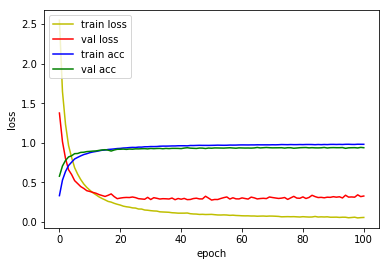

4815/4815 [==============================] - 2s 312us/sample - loss: 0.3583 - acc: 0.9142
Loss: 0.3582825439896044 Accuracy: 0.91422635

Train on 36805 samples, validate on 4293 samples
Epoch 1/200
36800/36805 [============================>.] - ETA: 0s - loss: 2.7526 - acc: 0.2901
Epoch 00001: val_loss improved from inf to 1.36044, saving model to model/checkpoint/2D_CNN_4_only_conv_DO_BN_checkpoint/01-1.3604.hdf5
36805/36805 [==============================] - 19s 516us/sample - loss: 2.7526 - acc: 0.2901 - val_loss: 1.3604 - val_acc: 0.5775
Epoch 2/200
36736/36805 [============================>.] - ETA: 0s - loss: 1.6616 - acc: 0.5148
Epoch 00002: val_loss improved from 1.36044 to 0.90515, saving model to model/checkpoint/2D_CNN_4_only_conv_DO_BN_checkpoint/02-0.9052.hdf5
36805/36805 [==============================] - 16s 444us/sample - loss: 1.6607 - acc: 0.5150 - val_loss: 0.9052 - val_acc: 0.7277
Epoch 3/200
36736/36805 [============================>.] - ETA: 0s - loss: 1.1590 - ac

36800/36805 [============================>.] - ETA: 0s - loss: 0.1694 - acc: 0.9459
Epoch 00024: val_loss improved from 0.20226 to 0.19471, saving model to model/checkpoint/2D_CNN_4_only_conv_DO_BN_checkpoint/24-0.1947.hdf5
36805/36805 [==============================] - 16s 439us/sample - loss: 0.1695 - acc: 0.9458 - val_loss: 0.1947 - val_acc: 0.9448
Epoch 25/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.1646 - acc: 0.9467
Epoch 00025: val_loss improved from 0.19471 to 0.18825, saving model to model/checkpoint/2D_CNN_4_only_conv_DO_BN_checkpoint/25-0.1883.hdf5
36805/36805 [==============================] - 16s 445us/sample - loss: 0.1646 - acc: 0.9466 - val_loss: 0.1883 - val_acc: 0.9485
Epoch 26/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.1555 - acc: 0.9500
Epoch 00026: val_loss did not improve from 0.18825
36805/36805 [==============================] - 16s 442us/sample - loss: 0.1554 - acc: 0.9500 - val_loss: 0.1935 - val_acc: 0.9464
E

Epoch 52/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0826 - acc: 0.9723
Epoch 00052: val_loss did not improve from 0.17971
36805/36805 [==============================] - 16s 439us/sample - loss: 0.0828 - acc: 0.9723 - val_loss: 0.2002 - val_acc: 0.9532
Epoch 53/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0822 - acc: 0.9726
Epoch 00053: val_loss did not improve from 0.17971
36805/36805 [==============================] - 16s 441us/sample - loss: 0.0824 - acc: 0.9726 - val_loss: 0.1970 - val_acc: 0.9513
Epoch 54/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0792 - acc: 0.9737
Epoch 00054: val_loss did not improve from 0.17971
36805/36805 [==============================] - 16s 443us/sample - loss: 0.0792 - acc: 0.9737 - val_loss: 0.2112 - val_acc: 0.9497
Epoch 55/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0749 - acc: 0.9748
Epoch 00055: val_loss did not improve from 0.17971
36805/36805 [=====

Epoch 82/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0538 - acc: 0.9817
Epoch 00082: val_loss did not improve from 0.17971
36805/36805 [==============================] - 16s 442us/sample - loss: 0.0541 - acc: 0.9816 - val_loss: 0.2097 - val_acc: 0.9527
Epoch 83/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0577 - acc: 0.9803
Epoch 00083: val_loss did not improve from 0.17971
36805/36805 [==============================] - 16s 439us/sample - loss: 0.0577 - acc: 0.9803 - val_loss: 0.2129 - val_acc: 0.9513
Epoch 84/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0502 - acc: 0.9831
Epoch 00084: val_loss did not improve from 0.17971
36805/36805 [==============================] - 16s 438us/sample - loss: 0.0504 - acc: 0.9830 - val_loss: 0.2169 - val_acc: 0.9506
Epoch 85/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0585 - acc: 0.9810
Epoch 00085: val_loss did not improve from 0.17971
36805/36805 [=====

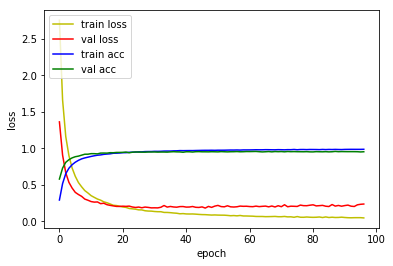

4815/4815 [==============================] - 2s 322us/sample - loss: 0.2462 - acc: 0.9333
Loss: 0.24619878661409716 Accuracy: 0.93333334



In [13]:
for i in range(1, 5):
    model_name = '2D_CNN_{}_only_conv_DO_BN'.format(i)
    model = build_2d_cnn_only_conv_DO_BN(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:02d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_2d_norm, y_train_onehot, batch_size=64, epochs=200, 
                     validation_data=[x_val_2d_norm, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print('{} Only Conv Model'.format(i))
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_2d_norm, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [14]:
for i in range(1, 5):
    model_name = '2D_CNN_{}_only_conv_DO_BN'.format(i)
    print()
    print(model_name, 'Model')
#         model = build_cnn(conv_num=i, fcn_num=j)
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
#         model_filename = model_path + '{epoch:02d}-{val_loss:.4f}.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_2d_norm, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)


2D_CNN_1_only_conv_DO_BN Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 253, 95, 8)        208       
_________________________________________________________________
batch_normalization_v1 (Batc (None, 253, 95, 8)        32        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 48, 8)        0         
_________________________________________________________________
flatten (Flatten)            (None, 48768)             0         
_________________________________________________________________
dropout (Dropout)            (None, 48768)             0         
_________________________________________________________________
dense (Dense)                (None, 16)                780304    
Total params: 780,544
Trainable params: 780,528
Non-trainable params: 16
_____________________________________